### Initialization

In [1]:
import os, glob
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from matplotlib.lines import Line2D

%matplotlib inline 
%load_ext autoreload
%autoreload 2

In [2]:
from network_flow_tracker import FlowGraph as FG
from network_flow_tracker import analysis as NFTAnalysis
from network_flow_tracker import visualization as NFTVis
from network_flow_tracker import LFBFP
from network_flow_tracker.utils import io, vis, stat, util, graph
from network_flow_tracker.utils import neighbors as nb

In [4]:
data_group = 'Lightfield'
dataset = 'Zhang2020'
data_root_path = f'C:\\Data\\{data_group}\\{dataset}'
process_data_root = os.path.join(data_root_path, 'processed_data')
vis_folder_root = os.path.join(data_root_path, 'visualization')

In [5]:
info_fp = os.path.join(process_data_root, 'data_info.pickle')
data_info = io.load_data(info_fp)
mm2s_to_pxl2s = 1e3 / data_info['frame_rate_Hz'] / data_info['target_voxel_size_um']
frame_rate_Hz = data_info['frame_rate_Hz']
avg_hematocrit = 0.5
cell_labeled_fraction = 0.1
z_num_frame = data_info['num_files']
lfp = LFBFP.LFBFProcessing(data_root_path, data_info)
voxel_size_um = data_info['target_voxel_size_um']
vis_z_name = 'combined_stat'
vis_folder = os.path.join(vis_folder_root, 'analysis', vis_z_name)
vis_fp_prefix = f"{data_group}_{dataset}_{vis_z_name}"

debug_Q = True
save_fig_Q = False

In [6]:
if len(set(z_num_frame)) == 1: 
    num_frame = z_num_frame[0]
else: 
    print(f"Different z positions have different number of files / frames: {z_num_frame}")

## Load and merge data

### Loading and registration

In [7]:
z_list = [0, 1, 2, 3, 4]
tk_data_dict = {}
# z_idx = 1
for z_idx in z_list: 
    z_folder_name = data_info['raw_data_folders'][z_idx]
    data_folder = os.path.join(process_data_root, 'tracking')
    data_fp = sorted(glob.glob(os.path.join(data_folder, f"{z_folder_name}_tk_w_pdt*")))
    if len(data_fp) > 1: 
        data_fp = data_fp[-1]
    else: 
        data_fp = data_fp[0]

    tk_data = io.load_data(data_fp)    
    tk_data_dict[z_idx] = tk_data
    print(f"Finish loading tracking data in {z_folder_name}")

Finish loading tracking data in z0_150um
Finish loading tracking data in z100_250um
Finish loading tracking data in z200_350um
Finish loading tracking data in z300_450um
Finish loading tracking data in z400_550um


In [11]:
graph_fp

'/net/birdstore/Vessel/Lightfield/Zhang2020/processed_data/itk/recon/whole_20250614_140908_data.mat'

In [12]:
graph_fp = set([tk_data_dict[i]['graph_version'] for i in z_list]) 
if len(graph_fp) == 1: 
    graph_fp = graph_fp.pop()
else: 
    raise ValueError(f"Tracking result was computed with different version of graph")
graph_fn = os.path.split(graph_fp)[-1]
graph_fp = os.path.join(process_data_root, 'itk', 'recon', graph_fn)
stitch_data = LFBFP.LFBFProcessing.load_and_parse_annotation_data(graph_fp)
whole_mask_size = stitch_data['mask_size']
fg = graph.SpatialGraph(stitch_data['skl_ind'], stitch_data['mask_size'])

skl_r_array = np.zeros(whole_mask_size, np.float16)
skl_r_array.flat[stitch_data['skl_ind']] = stitch_data['skl_r_pxl']
skl_label_array = np.zeros(whole_mask_size, dtype=np.int8)
skl_label_array.flat[stitch_data['skl_ind']] = stitch_data['skl_label']

fg = FG.FlowGraph(skl_label_array > 0)
fg.init_nearest_skl_map(vsl_skl_labeled=skl_label_array, vsl_vol_labeled=stitch_data['label_array_annotated'])
fg

21 skeleton voxels are labeled as artery in vsl_skl_labeled, but as capillary in vsl_vol_labeled. Correct to capillary.
135 skeleton voxels are labeled as vein in vsl_skl_labeled, but as capillary in vsl_vol_labeled. Correct to capillary.


Spatial graph with 3114 edges and 1751 nodes.

In [13]:
tmp = nb.bwconncomp(skl_label_array > 0)
tmp['num_pixel_per_cc'][0] / tmp['num_pixel_per_cc'].sum()

np.float64(0.9637304937418187)

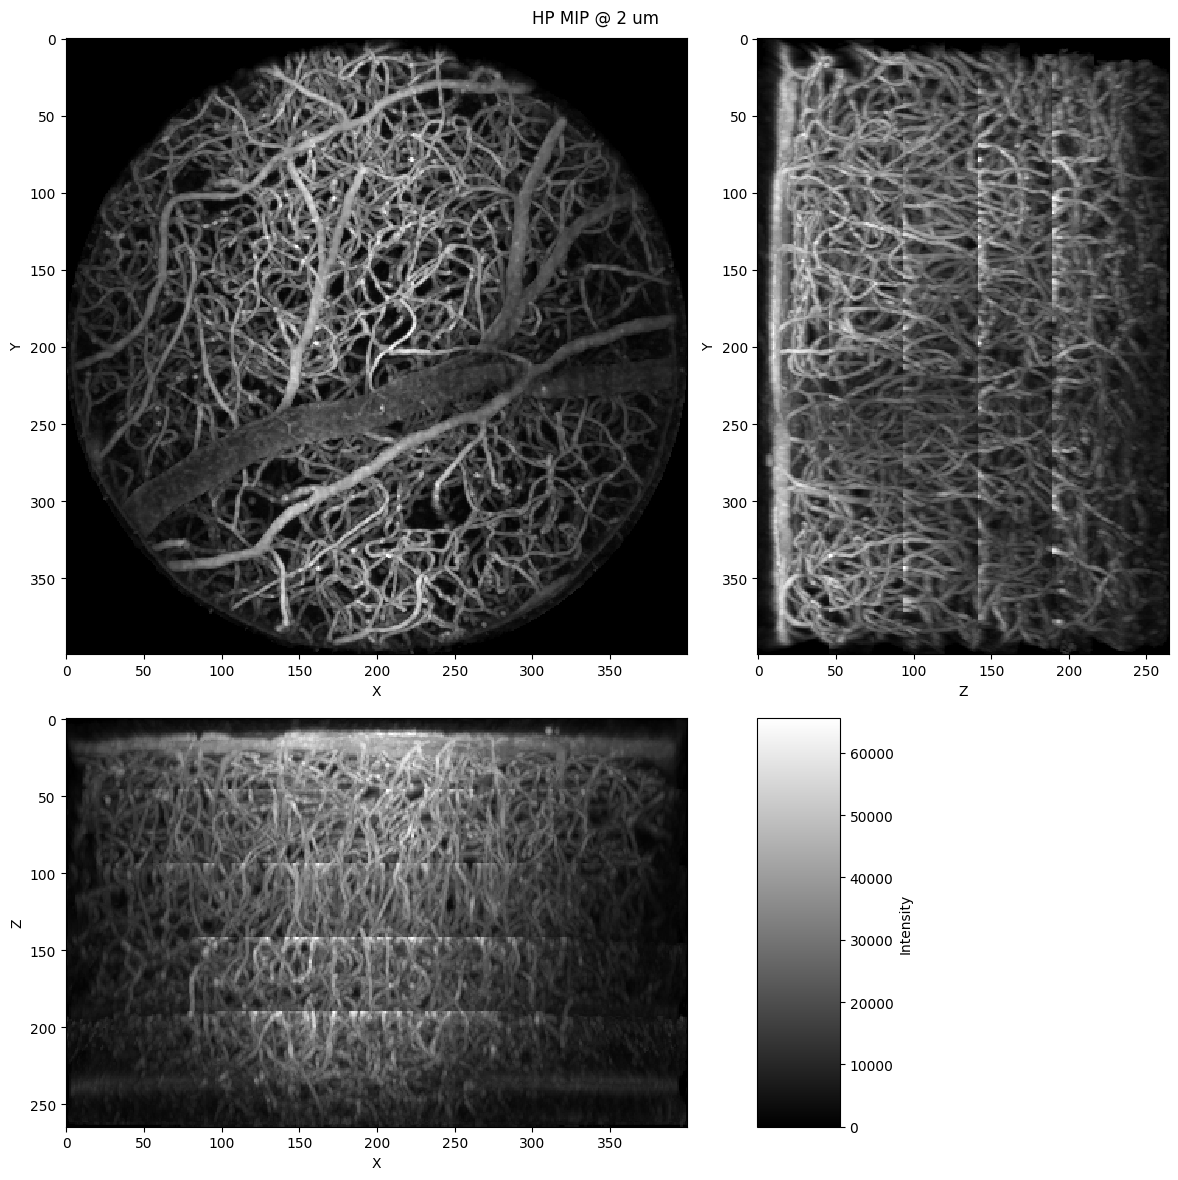

In [15]:
whole_im = stitch_data['stitched_im']
whole_im_mips = vis.compute_three_view_mip(whole_im)

f = vis.vis_mips(whole_im_mips, figsize=(12, 12), fig_title=f"HP MIP @ 2 um", show_axes_Q=True, colorbarQ=True, cbar_label='Intensity')
if save_fig_Q: 
    fp = os.path.join(vis_folder, f"{data_group}_{dataset}_Whole_vol_hp_mip.png")
    io.print_image_in_several_formats(f, fp)

In [16]:
layer_stat = {}
for z_idx in [0, 1, 2, 3, 4]: 
# z_idx = 1
    tmp_z_folder = data_info['raw_data_folders'][z_idx]
    tmp_fp = os.path.join(process_data_root, 'analysis', f"MV_{tmp_z_folder}.pickle")
    tmp_data = io.load_data(tmp_fp)

    tmp_skl_label_array = tmp_data['fg']['vsl_skl_labeled']
    tmp_vsl_vol_labeled = tmp_data['fg']['vsl_vol_labeled']
    tmp_fg = FG.FlowGraph(tmp_skl_label_array > 0)
    tmp_fg.init_nearest_skl_map(vsl_skl_labeled=tmp_skl_label_array, vsl_vol_labeled=tmp_vsl_vol_labeled)
    tmp_fg.init_velocity(tmp_data['fg']['edge_v_pxl'], tmp_data['fg']['edge_v_std_pxl'])
    tmp_data['fg'] = tmp_fg
    layer_stat[z_idx] = tmp_data
    print(f"Finish loading statistics in layer {z_idx}")

Finish loading statistics in layer 0
Finish loading statistics in layer 1
Finish loading statistics in layer 2
Finish loading statistics in layer 3
Finish loading statistics in layer 4


In [8]:
bbox_ll = (data_info['bbox_ll'] * data_info['voxel_size_um'] / data_info['target_voxel_size_um']).astype(np.int16)
bbox_mmxx_z = (np.asarray(data_info['z_valid_range_um']) / data_info['target_voxel_size_um']).astype(np.int16)
bbox_mm_zyx = np.vstack([(np.asarray([z[0], 0, 0]) + v).astype(np.int16) for z, v in zip(bbox_mmxx_z, stitch_data['disp_vec_c'])])
bbox_xx_zyx = bbox_mm_zyx + bbox_ll[None, :]

In [9]:
map_gel_to_svel = NFTAnalysis.get_cc_label_map_in_subvolume_graphs(fg, bbox_mm_zyx, bbox_xx_zyx, layer_stat, 'edge')

Finish matching edge 0.

Finish matching edge 3113.

In [10]:
map_gnl_to_svnl = NFTAnalysis.get_cc_label_map_in_subvolume_graphs(fg, bbox_mm_zyx, bbox_xx_zyx, layer_stat, 'node')
map_svnl_to_gnl = {vv:k for k, v in map_gnl_to_svnl.items() for vv in v}

Finish matching node 0.

Finish matching node 1750.

### Combine cc statistics

In [11]:
# selection criteria: 
# longer parent edge? or more counts? 
n_fbf_data = defaultdict(dict)
for tmp_sv_idx in list(layer_stat.keys()): 
    # tmp_sv_idx = 0
    tmp_sv_n_fbf = layer_stat[tmp_sv_idx]['n_fbf_data']
    for i, tmp_sv_nl in enumerate(tmp_sv_n_fbf['key']): 
        tmp_nl = map_svnl_to_gnl[(tmp_sv_idx, tmp_sv_nl)]
        tmp_update_Q = False
        if (tmp_nl not in n_fbf_data): 
            tmp_update_Q = True
        elif (n_fbf_data[tmp_nl]['p_e_length'] < tmp_sv_n_fbf['p_e_length'][i]): 
            tmp_update_Q = True
        elif np.all(n_fbf_data[tmp_nl]['c_e_length'] <= tmp_sv_n_fbf['c_e_length'][i]): 
            tmp_update_Q = True

        if tmp_update_Q: 
            tmp_dict = {k: v[i] for k, v in tmp_sv_n_fbf.items()}
            n_fbf_data[tmp_nl] = tmp_dict

n_fbf_data = util.dict_of_dict_to_dict_of_array(n_fbf_data, to_numpy_Q=True)

In [12]:
# selection criteria: 
# longer parent edge? or more counts? 
ps_ns_stat = defaultdict(dict)
for tmp_sv_idx in list(layer_stat.keys()): 
    # tmp_sv_idx = 0
    tmp_sv_n_fbf = layer_stat[tmp_sv_idx]['ps_ns_stat']
    for i, tmp_sv_nl in enumerate(tmp_sv_n_fbf['node_label']): 
        tmp_nl = map_svnl_to_gnl[(tmp_sv_idx, tmp_sv_nl)]
        tmp_update_Q = False
        if (tmp_nl not in ps_ns_stat): 
            tmp_update_Q = True
        elif (ps_ns_stat[tmp_nl]['max'] < tmp_sv_n_fbf['max'][i]): 
            tmp_update_Q = True
        elif np.all(ps_ns_stat[tmp_nl]['sum'] <= tmp_sv_n_fbf['sum'][i]): 
            tmp_update_Q = True

        if tmp_update_Q: 
            tmp_dict = {k: v[i] for k, v in tmp_sv_n_fbf.items()}
            ps_ns_stat[tmp_nl] = tmp_dict

ps_ns_stat = util.dict_of_dict_to_dict_of_array(ps_ns_stat, to_numpy_Q=True)

In [13]:
# Merge edge features and traces
cp_ef_list = layer_stat[0]['edge_features'].keys()
cp_ef_dict = {}
for k, v in layer_stat[0]['edge_features'].items():
    if 'vec' in k: 
        tmp_k_sz = (fg.edge.num_cc, 3)
    else: 
        tmp_k_sz = (fg.edge.num_cc, )
    cp_ef_dict[k] = np.full(tmp_k_sz, np.nan)
cp_ef_dict['consistentQ'] = np.zeros(fg.edge.num_cc, bool)

edges_traces = {}
dir_keys = ['v', 'v_sm']
dir_traces_key = ['skl_v_mean', 'skl_v_med', 'e_t_v_mean', 'e_t_v_mean_sm', 'p_t_v_mean', 'p_t_v_mean_sm']
dir_traces_stat_key = ['stat_v', 'stat_skl_v', 'stat_e_v', 'stat_p_v']
dir_stat_key = ['mean', 'median']
for tmp_el in range(fg.edge.num_cc):
    tmp_sv_els = map_gel_to_svel[tmp_el]
    if len(tmp_sv_els) >= 1: 
        tmp_data = {k: np.nan for k in cp_ef_list}
        tmp_consistent_Q = True
        for tmp_sv_el in tmp_sv_els:
            tmp_sv_idx, tmp_sv_el, tmp_dir = tmp_sv_el
            tmp_sv_data = layer_stat[tmp_sv_idx]['edge_features']
            tmp_consistent_Q = np.isnan(tmp_data['length']) # value hasn't been assigned yet
            if tmp_consistent_Q or tmp_data['length'] < tmp_sv_data['length'][tmp_sv_el]: 
                for k in tmp_data.keys():
                    tmp_v = tmp_sv_data[k][tmp_sv_el]
                    if k in dir_keys: 
                        tmp_v *= tmp_dir
                    tmp_data[k] = tmp_v
                if tmp_sv_el in layer_stat[tmp_sv_idx]['edges_traces']: 
                    tmp_e_traces = layer_stat[tmp_sv_idx]['edges_traces'][tmp_sv_el].copy()
                    for k in dir_traces_key: 
                        # The speed statistics has not been corrected yet
                        tmp_e_traces[k] *= tmp_dir
                    for k in dir_traces_stat_key: 
                        for kk in dir_stat_key: 
                            tmp_e_traces[k][kk] *= tmp_dir
                        
                    edges_traces[tmp_el] = tmp_e_traces
                # Need to determine the direction of the edges 
        
        for k in tmp_data.keys():
            cp_ef_dict[k][tmp_el] = tmp_data[k]
        cp_ef_dict['consistentQ'][tmp_el] = tmp_consistent_Q

## Overall statistics

### Edge flow features

In [14]:
# Get edge vessel type
map_ind_to_type = nb.construct_array_sparse_representation(stitch_data['skl_ind'], [np.prod(stitch_data['mask_size']), 1], 
                                                           stitch_data['skl_label'].flatten().astype(np.int8))

edge_features = fg.edge.compute_geometric_features(fg.edge.cc_ind, whole_mask_size, ep_vec_nb=8)
edge_features['type'] = fg.edge.get_cc_feature_from_voxel_array(map_ind_to_type, stat=['mode'])['mode']
# The vessel radius estimation is not very reliable here. Use the vessel type only for branch order calculation 
source_type = 2
end_type = 3
vsl_type = edge_features['type'].astype(np.int8)
artery_label = np.nonzero(vsl_type == source_type)[0]
vein_label = np.nonzero(vsl_type == end_type)[0]
edge_features['BOA'] = fg.compute_edge_branch_order(source_label=artery_label, drain_label=vein_label)
edge_features['BOV'] = fg.compute_edge_branch_order(source_label=vein_label, drain_label=artery_label)

In [ ]:
from sklearn.linear_model import LinearRegression
from scipy.stats import linregress

Finish saving figure as /net/birdstore/Vessel/Lightfield/Zhang2020/visualization/analysis/combined_stat/branch_order/Lightfield_Zhang2020_combined_stat_BOA_BOV_hist2.pdf
Finish saving figure as /net/birdstore/Vessel/Lightfield/Zhang2020/visualization/analysis/combined_stat/branch_order/Lightfield_Zhang2020_combined_stat_BOA_BOV_hist2.pickle
Finish saving figure as /net/birdstore/Vessel/Lightfield/Zhang2020/visualization/analysis/combined_stat/branch_order/Lightfield_Zhang2020_combined_stat_BOA_BOV_hist2.png


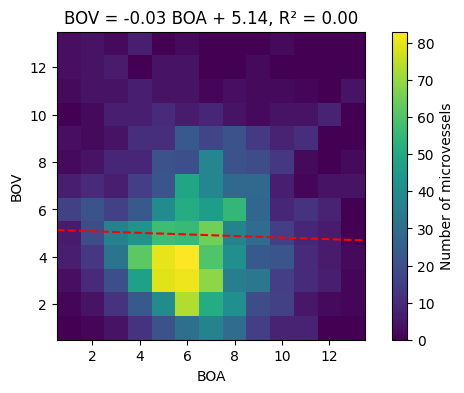

In [ ]:
# Reviewer questions
f, a = plt.subplots(1, 1, figsize=(7, 4))
tmp_x = edge_features['BOA']
tmp_y = edge_features['BOV']
tmp_selected_Q = (tmp_x >= 1) & (tmp_y >= 1)
tmp_selected_Q = tmp_selected_Q & (tmp_x < 14) & (tmp_y < 14)
tmp_x = tmp_x[tmp_selected_Q]
tmp_y = tmp_y[tmp_selected_Q]
tmp_bin_edge = np.arange(1, 15) - 0.5
tmp = a.hist2d(tmp_x, tmp_y, bins=tmp_bin_edge)
a.set_xlabel('BOA')
a.set_ylabel('BOV')
cbar = f.colorbar(tmp[3], ax=a)
cbar.set_label('Number of microvessels')
# set aspect ratio to 1
a.set_aspect('equal', adjustable='box')
# a.scatter(edge_features['BOA'], edge_features['BOV'])
# linear regression to get correlation coefficient
model = LinearRegression()
model.fit(tmp_x.reshape(-1, 1), tmp_y)
slope = model.coef_[0]
intercept = model.intercept_
corr_coef = model.score(tmp_x.reshape(-1, 1), tmp_y)
a.set_title(f"BOV = {slope:.2f} BOA + {intercept:.2f}, R² = {corr_coef:.2f}")
# plot the line 
x_vals = np.array(a.get_xlim())
y_vals = intercept + slope * x_vals
a.plot(x_vals, y_vals, '--', color='red')


if save_fig_Q or True:
    fig_fp = os.path.join(vis_folder, 'branch_order', f"{vis_fp_prefix}_BOA_BOV_hist2.png")
    io.print_image_in_several_formats(f, fig_fp)

In [15]:
edge_features['BOV'][edge_features['BOA'] == 0]

array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1], dtype=int16)

In [49]:
# Compute loop statistics
edge_features['loop_length_um'], edge_features['loop_num_edge'] = graph.AbstractGraph.compute_shortest_loop_length(fg, weighted_Q=False)

In [50]:
node_features = {}
node_features['type'] = fg.node.get_cc_feature_from_voxel_array(map_ind_to_type, stat=['mode'])['mode']
artery_label = np.nonzero(node_features['type'] == source_type)[0]
vein_label = np.nonzero(node_features['type'] == end_type)[0]
node_features['BOA'] = fg.compute_node_branch_order(source_label=artery_label, drain_label=vein_label)
node_features['BOV'] = fg.compute_node_branch_order(source_label=vein_label, drain_label=artery_label)
# node_features |= cp_nf_dict

In [51]:
p_t_v_stat = {k: np.full(fg.edge.num_cc, np.nan) for k in ['med', 'num_data', 'eff_cv', 'sm_eff_cv', 'v_rev_ratio']}
for i, tmp_et_data in edges_traces.items():
    p_t_v_stat['v_rev_ratio'][i] = tmp_et_data['stat_p_v']['reverse_frac']
    p_t_v_stat['med'][i] = tmp_et_data['stat_p_v']['median'] 

    tmp_stat = stat.compute_basic_statistics(tmp_et_data['p_t_v_mean'])
    p_t_v_stat['eff_cv'][i] = tmp_stat['eff_ptrl_cv']
    tmp_stat_sm =  stat.compute_basic_statistics(tmp_et_data['p_t_v_mean_sm'])
    p_t_v_stat['sm_eff_cv'][i] = tmp_stat_sm['eff_ptrl_cv']
    
    p_t_v_stat['num_data'][i] = tmp_et_data['stat_p_v']['num_data']

/home/xij072/Documents/Github/Network_flow/utils/stat.py:39: RuntimeWarning: invalid value encountered in sqrt
  stat['std'] = np.sqrt(mean_x2 - stat['mean'] ** 2)


In [ ]:
frame_rate_Hz = data_info['frame_rate_Hz']

edge_features['v'] = np.abs(p_t_v_stat['med']) # this is speed
edge_features['v_cv'] = p_t_v_stat['eff_cv']
edge_features['v_sm_cv'] = p_t_v_stat['sm_eff_cv']
edge_features['l2v'] = np.abs(edge_features['length'] / (edge_features['v'] * frame_rate_Hz))
edge_features['p_v_rev_frac'] = p_t_v_stat['v_rev_ratio']
edge_features['num_p'] = p_t_v_stat['num_data']

In [53]:
# Node features
nfc_info = fg.compute_node_flow_configuration(known_edge_v=p_t_v_stat['med'])

for tmp_el in ['num_in', 'num_out', 'num_unknown']: 
    node_features[tmp_el] = nfc_info[f'n_{tmp_el}'].astype(np.int8)
node_features['is_1_in_Q'] = np.logical_and(np.logical_and(node_features['num_in'] == 1, node_features['num_unknown'] == 0), node_features['num_out'] > 1)
node_features['is_1_out_Q'] = np.logical_and(np.logical_and(node_features['num_out'] == 1, node_features['num_unknown'] == 0), node_features['num_in'] > 1)

In [54]:
min_data = 25
tmp_valid_Q = n_fbf_data['p_num_cell'] >= min_data
tmp_valid_Q = np.logical_and(tmp_valid_Q, np.logical_and(n_fbf_data['BOA'] >= 1, n_fbf_data['BOA'] <= 8))
tmp_valid_Q = np.logical_and(tmp_valid_Q, np.all(np.isfinite(n_fbf_data['c_ps_p_m']), axis=1))
tmp_valid_Q = np.logical_and(tmp_valid_Q, np.all(np.isfinite(n_fbf_data['c_avg_vf_r']), axis=1))
vis_fbf_data = util.mask_data_in_dict(n_fbf_data, tmp_valid_Q)

vis_fb_vs_BOA_t = pd.DataFrame({'node_label': vis_fbf_data['key'],
                          'BOA': vis_fbf_data['BOA'].astype(np.uint16), 
                          'p_c1': np.max(vis_fbf_data['c_ps_p_m'], axis=1), 
                          'v_bias_ratio': 2 * (np.max(vis_fbf_data['c_avg_v_r'], axis=1) - 0.5), 
                          'v_raw_bias_ratio': 2 * (np.max(vis_fbf_data['c_avg_v_r_raw'], axis=1) - 0.5), 
                          'vf_bias_ratio':  2* (np.max(vis_fbf_data['c_avg_vf_r'], axis=1) - 0.5)})

In [55]:
num_t_pts = num_frame
ps_ns_stat['ns_max_duration_s'] = ps_ns_stat['max'] / frame_rate_Hz
ps_ns_stat['ns_duration_f'] = ps_ns_stat['sum'] / num_t_pts
ps_ns_stat['BOA'] = node_features['BOA'][ps_ns_stat['key']]
ps_ns_stat['BOV'] = node_features['BOV'][ps_ns_stat['key']]

## Vessel branch order

### Edge features

In [ ]:
vis_max_val = 10
for vis_bo_name in ['BOA', 'BOV']:
# vis_bo_name = 'BOV'
    vis_vxl_BO = fg.edge.get_cc_vxl_value_from_cc_feature(edge_features[vis_bo_name], concatenated_Q=True)
    vis_BO_vol = np.zeros(whole_mask_size, dtype=np.int8) - 1
    vis_BO_vol.flat[fg.edge.pos_ind] = vis_vxl_BO
    if vis_max_val is not None: 
        vis_BO_vol = np.minimum(vis_BO_vol, vis_max_val)
    vis_BOA_mips = vis.compute_three_view_mip(vis_BO_vol)
    if vis_bo_name == 'BOA': 
        vis_cmap = 'jet0r'
    elif vis_bo_name == 'BOV':
        vis_cmap = 'jet0'
    fig = vis.vis_mips(vis_BOA_mips, cmap=vis_cmap, figsize=(10, 10), colorbarQ=True, cbar_label=f"{vis_bo_name}", c_scale='normal', show_axes_Q=False, fig_title=f"Whole graph {vis_bo_name}")
    if save_fig_Q:
        fig_fp = os.path.join(vis_folder, 'branch_order', f"{vis_fp_prefix}_{vis_bo_name}_capped_{vis_max_val}_{vis_cmap}.png" )
        io.print_image_in_several_formats(fig, fig_fp)

In [ ]:
f = plt.figure()
a1 = f.add_subplot(2, 1, 1)
vis_1_bins = np.arange(-0.5, 17.5, 1)
a1.hist(edge_features['BOA'], bins=vis_1_bins, alpha=0.5, label='BOA', edgecolor='k')
a1.hist(edge_features['BOV'], bins=vis_1_bins, alpha=0.5, label='BOV', edgecolor='k')
a1.set_xlabel("Branch order")
a1.set_ylabel("Number of edges")
a1.set_title("Whole graph")
a1.legend()
a1.grid()

a2 = f.add_subplot(2, 1, 2)
a2.hist(edge_features['BOA'], bins=vis_1_bins, alpha=0.5, label='BOA', edgecolor='k', density=True, cumulative=True)
a2.hist(edge_features['BOV'], bins=vis_1_bins, alpha=0.5, label='BOV', edgecolor='k', density=True, cumulative=True)
a2.set_xlabel("Branch order")
a2.set_ylabel("Number of edges")
a2.set_title("Whole graph")
a2.legend()
a2.grid()
f.tight_layout()

if save_fig_Q or True:
    fig_fp = os.path.join(vis_folder, 'branch_order', f"{vis_fp_prefix}_branch_order_hist.png" )
    io.print_image_in_several_formats(f, fig_fp)

In [56]:
# Branch order from artery to vein: 
bov_1_el = np.nonzero(edge_features['BOV'] == 1)[0]
boa_1_el = np.nonzero(edge_features['BOA'] == 1)[0]
bov_1_e_boa = edge_features['BOA'][bov_1_el]
bov_1_e_boa_stat = stat.compute_basic_statistics(bov_1_e_boa)
boa_1_e_bov = edge_features['BOV'][boa_1_el]
bov_1_e_bov_stat = stat.compute_basic_statistics(boa_1_e_bov)

In [57]:
def stat_to_string(tmp):
    return f"# Data: {tmp['num_data']}\nMean,SD: {tmp['mean']:.2e},{tmp['std']:.2e}\nMedian: {tmp['median']:.2e}\n"

Finish saving figure as /net/birdstore/Vessel/Lightfield/Zhang2020/visualization/analysis/combined_stat/combined_stat_AV_BO_spacing.pdf
Finish saving figure as /net/birdstore/Vessel/Lightfield/Zhang2020/visualization/analysis/combined_stat/combined_stat_AV_BO_spacing.pickle
Finish saving figure as /net/birdstore/Vessel/Lightfield/Zhang2020/visualization/analysis/combined_stat/combined_stat_AV_BO_spacing.png


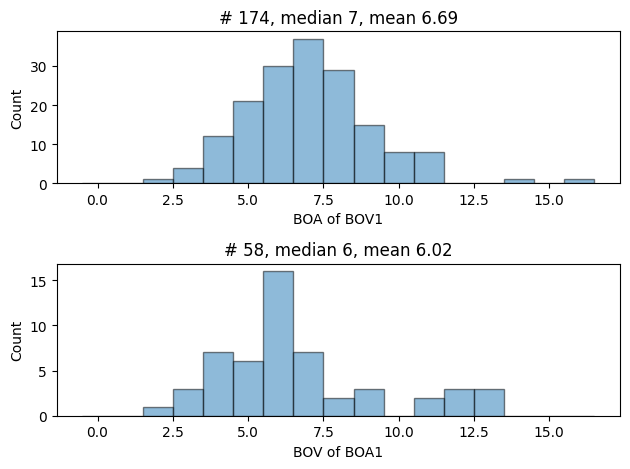

In [30]:
vis_1_bins = np.arange(-0.5, 17.5, 1)
f, a = plt.subplots(2, 1)
a[0].hist(bov_1_e_boa, bins=vis_1_bins, alpha=0.5, label='BOA of BOV1', edgecolor='k')
a[0].set_title(f"# {bov_1_e_boa_stat['num_data']}, median {int(bov_1_e_boa_stat['median'])}, mean {bov_1_e_boa_stat['mean']:.2f}")

a[0].set_ylabel("Count")
a[0].set_xlabel("BOA of BOV1")
a[1].hist(boa_1_e_bov, bins=vis_1_bins, alpha=0.5, label='BOV of BOA1', edgecolor='k')
a[1].set_title(f"# {bov_1_e_bov_stat['num_data']}, median {int(bov_1_e_bov_stat['median'])}, mean {bov_1_e_bov_stat['mean']:.2f}")
a[1].set_ylabel("Count")
a[1].set_xlabel("BOV of BOA1")
f.tight_layout()

if save_fig_Q or True:
    fp = os.path.join(vis_folder, f"{vis_z_name}_AV_BO_spacing.png")
    io.print_image_in_several_formats(f, fp)

In [58]:
edge_f_t = pd.DataFrame.from_dict({k:v for k, v in edge_features.items() if k not in ['ep2ep_vec_n', 'ep1_dir_vec', 'ep2_dir_vec']})

In [ ]:
bo_var_name = 'loop_num_edge'
# bo_var_name = 'loop_length_um'
max_bo = 8
f = plt.figure(figsize=(8, 6))
for i, bo_name in enumerate(['BOA', 'BOV']): 
    vis_df = edge_f_t[(edge_f_t[bo_name] >= 1) & (edge_f_t[bo_name] <= max_bo)]
    a = f.add_subplot(2, 1, i+1)
    sns.boxplot(x=bo_name, y=bo_var_name, data=vis_df)
    # sns.violinplot(x=bo_name, y=bo_var_name, data=vis_df, inner='quartile')
    vis_g = vis_df.groupby(bo_name)[bo_var_name]
    vis_count = vis_g.count()
    vis_med = vis_g.median()
    for i, idx in enumerate(vis_count.index):
        a.text(i, vis_med[idx], f'n={vis_count[idx]}', ha='center', fontsize=12, color='black')
    a.set_xlabel(bo_name)
    if bo_var_name == 'loop_length_um': b
        a.set_ylabel('Shortest loop length (um)')
    elif bo_var_name == 'loop_num_edge': 
        a.set_ylabel('# Edges in the shortest loop')
    a.grid()
    a.set_ylim(0)
f.tight_layout()

if save_fig_Q:
    fp = os.path.join(vis_folder, f"Edge_{bo_var_name}_vs_BO_max_{max_bo}.png")
    io.print_image_in_several_formats(f, fp)

One question might be, whethere these differences across branch orders are significant

### Speed vs branch order

In [59]:
edge_f_t['v_mm2s'] = edge_features['v'] / 1e3
min_num_p = 25
edge_f_t = edge_f_t[edge_f_t['num_p'] >= min_num_p]
edge_f_t.shape

(2081, 15)

Finish saving figure as /net/birdstore/Vessel/Lightfield/Zhang2020/visualization/analysis/combined_stat/Edge_med_speed_vs_BO_max_8_min_p_25.pdf
Finish saving figure as /net/birdstore/Vessel/Lightfield/Zhang2020/visualization/analysis/combined_stat/Edge_med_speed_vs_BO_max_8_min_p_25.pickle
Finish saving figure as /net/birdstore/Vessel/Lightfield/Zhang2020/visualization/analysis/combined_stat/Edge_med_speed_vs_BO_max_8_min_p_25.png


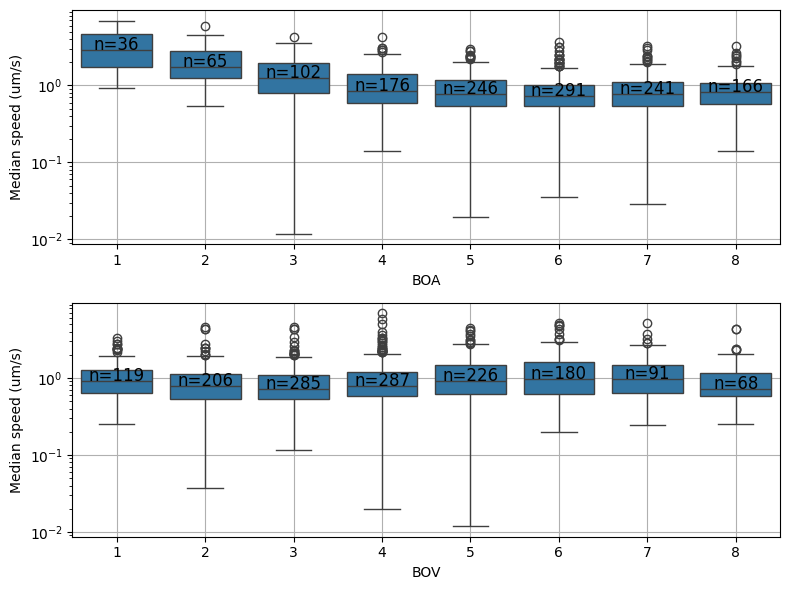

In [41]:
bo_var_name = 'v_mm2s'
max_bo = 8
f = plt.figure(figsize=(8, 6))
for i, bo_name in enumerate(['BOA', 'BOV']): 
    vis_df = edge_f_t[(edge_f_t[bo_name] >= 1) & (edge_f_t[bo_name] <= max_bo) & (edge_f_t[bo_var_name] > 0) 
                      & ((edge_f_t['p_v_rev_frac'] < 0.1))]
    a = f.add_subplot(2, 1, i+1)
    sns.boxplot(x=bo_name, y=bo_var_name, data=vis_df)
    # sns.violinplot(x=bo_name, y=bo_var_name, data=vis_df, inner='quartile')
    vis_g = vis_df.groupby(bo_name)[bo_var_name]
    vis_count = vis_g.count()
    vis_med = vis_g.median()
    for i, idx in enumerate(vis_count.index):
        a.text(i, vis_med[idx], f'n={vis_count[idx]}', ha='center', fontsize=12, color='black')
    a.set_xlabel(bo_name)
    a.set_ylabel("Median speed (um/s)")
    a.grid()
    a.set_yscale('log')
f.tight_layout()

if save_fig_Q:
    fp = os.path.join(vis_folder, f"Edge_med_speed_vs_BO_max_{max_bo}_min_p_{min_num_p}.png")
    io.print_image_in_several_formats(f, fp)

Finish saving figure as /net/birdstore/Vessel/Lightfield/Zhang2020/visualization/analysis/combined_stat/Edge_v_cv_eqv_cv_vs_BO_min_p_25.pdf
Finish saving figure as /net/birdstore/Vessel/Lightfield/Zhang2020/visualization/analysis/combined_stat/Edge_v_cv_eqv_cv_vs_BO_min_p_25.pickle
Finish saving figure as /net/birdstore/Vessel/Lightfield/Zhang2020/visualization/analysis/combined_stat/Edge_v_cv_eqv_cv_vs_BO_min_p_25.png


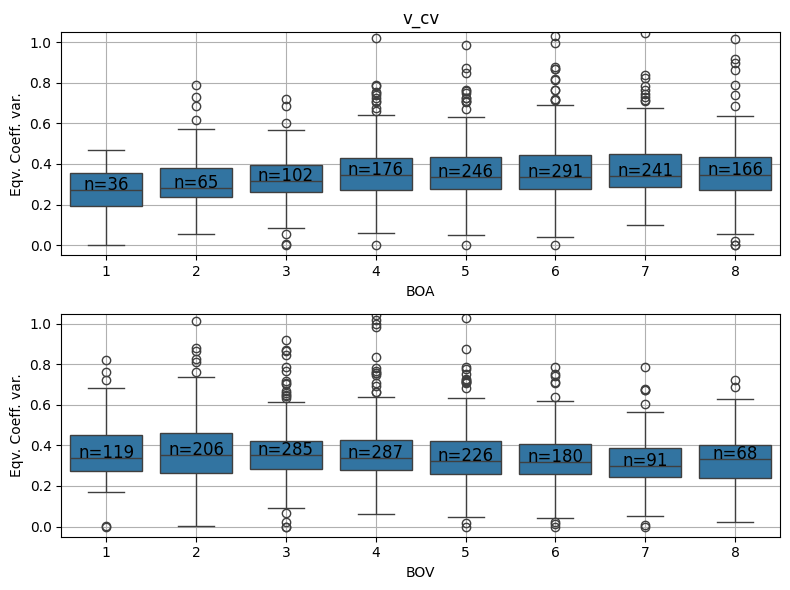

In [ ]:
bo_var_name = 'v_cv'
# bo_var_name = 'v_sm_cv'
f = plt.figure(figsize=(8, 6))
med_val = {}
for i, bo_name in enumerate(['BOA', 'BOV']): 
    vis_df = edge_f_t[(edge_f_t[bo_name] >= 1) & (edge_f_t[bo_name] <= max_bo) & (edge_f_t['v_mm2s'] > 0) 
                      & ((edge_f_t['p_v_rev_frac'] < 0.1))]
    a = f.add_subplot(2, 1, i+1)
    sns.boxplot(x=bo_name, y=bo_var_name, data=vis_df)
    # sns.violinplot(x=bo_name, y=bo_var_name, data=vis_df, inner='quartile')
    vis_g = vis_df.groupby(bo_name)[bo_var_name]
    vis_count = vis_g.count()
    vis_med = vis_g.median()
    med_val[bo_name] = vis_med
    # print(vis_med)
    for j, idx in enumerate(vis_count.index):
        a.text(j, vis_med[idx], f'n={vis_count[idx]}', ha='center', fontsize=12, color='black')
    a.set_xlabel(bo_name)
    a.set_ylabel("Eqv. Coeff. var.")
    a.grid()
    if bo_var_name == 'v_cv': 
        a.set_ylim(-0.05, 1.05)
    elif bo_var_name == 'v_sm_cv': 
        a.set_ylim(-0.05, 0.55)
    if i == 0: 
        a.set_title(f"{bo_var_name}")
f.tight_layout()
if save_fig_Q or True: 
    fp = os.path.join(vis_folder, f"Edge_{bo_var_name}_eqv_cv_vs_BO_min_p_{min_num_p}.png")
    io.print_image_in_several_formats(f, fp)

In [53]:
predict_feature = 'BOA'
if predict_feature == 'BOA': 
    feature_dir = 1
elif predict_feature == 'BOV': 
    feature_dir = -1
n_bo_dir = np.zeros(fg.edge.num_cc, np.int8)
for i_e in range(fg.edge.num_cc):
    tmp_n_p = fg.edge.connected_node_label[i_e]
    if np.all(tmp_n_p >= 0): 
        tmp_n_bo = node_features[predict_feature][tmp_n_p]
        if tmp_n_bo[0] < tmp_n_bo[1]: 
            n_bo_dir[i_e] = feature_dir
        elif tmp_n_bo[0] > tmp_n_bo[1]: 
            n_bo_dir[i_e] = -feature_dir
            
# Compare with the flow direction
tmp_same_Q = (p_t_v_stat['med'] * n_bo_dir) > 0
tmp_num_same = np.count_nonzero(tmp_same_Q)

### Node flow configuration vs branch order

In [60]:
node_feature_t = pd.DataFrame(node_features)

In [61]:
node_feature_t[(node_feature_t['BOA'] >= 1) & (node_feature_t['BOA'] <= 8)].shape

(1353, 8)

[ 31  50  83 102 101 100  73  52], [  1   7  15  56 104 109  81  52], 592, 425
[ 33  87 131 126 117  70  39  21], [81 84 75 70 53 50 34 22], 624, 469
Finish saving figure as /net/birdstore/Vessel/Lightfield/Zhang2020/visualization/analysis/combined_stat/Node_flow_config.pdf
Finish saving figure as /net/birdstore/Vessel/Lightfield/Zhang2020/visualization/analysis/combined_stat/Node_flow_config.pickle
Finish saving figure as /net/birdstore/Vessel/Lightfield/Zhang2020/visualization/analysis/combined_stat/Node_flow_config.png


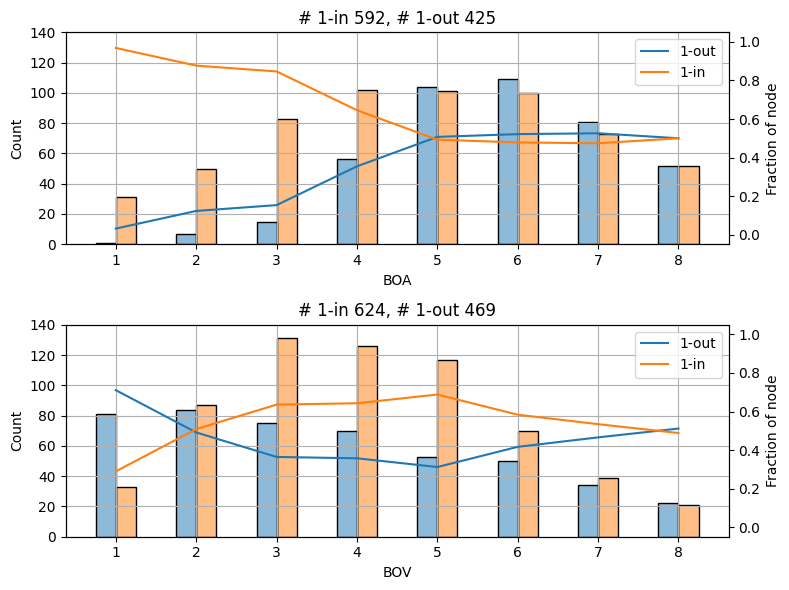

In [91]:
f = plt.figure(figsize=(8, 6))
for i, bo_name in enumerate(['BOA', 'BOV']): 
    vis_df = node_feature_t[(node_feature_t[bo_name] >= 1) & (node_feature_t[bo_name] <= 8) & (node_feature_t['num_unknown'] == 0)]
    vis_df = vis_df[(vis_df['num_in'] == 1) | (vis_df['num_out'] == 1)]

    vis_g = vis_df.groupby(bo_name)
    vis_gm = vis_g.mean()
    vis_x = vis_gm['is_1_in_Q'].index.values
    vis_avg_in = vis_gm['is_1_in_Q'].values
    vis_avg_out = vis_gm['is_1_out_Q'].values
    
    vis_g = vis_df.groupby(bo_name)
    vis_count = vis_g.sum()
    vis_count_in = vis_count['is_1_in_Q'].values
    vis_count_out = vis_count['is_1_out_Q'].values
    print(f"{vis_count_in}, {vis_count_out}, {np.sum(vis_count_in)}, {np.sum(vis_count_out)}")
    
    a = f.add_subplot(2, 1, i+1)
    sns.histplot(data=vis_df, x=bo_name, hue='is_1_in_Q', bins=np.arange(0.5, 9.5), multiple="dodge", kde=False, alpha=0.5, legend=False, shrink=0.5)
    a.set_ylim([0, 140])

    a2 = a.twinx()
    a2.plot(vis_x, vis_avg_out, label='1-out')
    a2.plot(vis_x, vis_avg_in, label='1-in')
    a2.set_ylim([-0.05, 1.05])
    a2.legend()    
    a2.set_ylabel("Fraction of node")

    a.set_title(f"# 1-in {np.sum(vis_count_in)}, # 1-out {np.sum(vis_count_out)}")
    a.set_xlabel(bo_name)
    a.grid()
    f.tight_layout()
if save_fig_Q: 
    fp = os.path.join(vis_folder, f"Node_flow_config.png")
    io.print_image_in_several_formats(f, fp)

### 1-in-N-out node partition fraction

In [ ]:
z_folder_name = vis_z_name

'combined_stat'

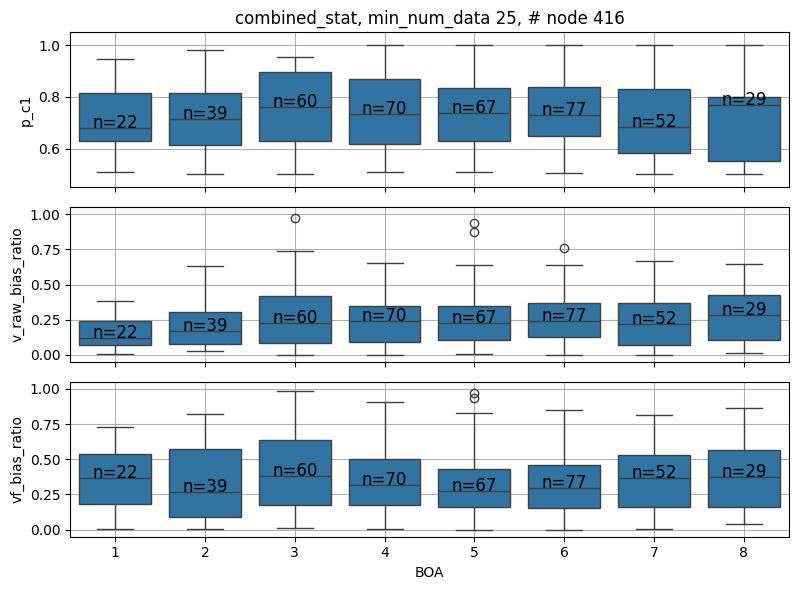

In [64]:
y_var_name = 'p'
bo_name = 'BOA'
f, axes = plt.subplots(3, 1, sharex=True, figsize=(8, 6))
for i, y_var_name in enumerate(['p_c1', 'v_raw_bias_ratio', 'vf_bias_ratio']): 
    # a = f.add_subplot()
    a = axes[i]
    sns.boxplot(ax=a, x=bo_name, y=y_var_name, data=vis_fb_vs_BOA_t)
    # sns.violinplot(x=bo_name, y=bo_var_name, data=vis_df, inner='quartile')
    vis_g = vis_fb_vs_BOA_t.groupby(bo_name)[y_var_name]
    vis_count = vis_g.count()
    vis_med = vis_g.median()
    for t_x, idx in enumerate(vis_count.index):
        a.text(t_x, vis_med[idx], f'n={vis_count[idx]}', ha='center', fontsize=12, color='black')
    a.grid()
    if i == 0: 
        a.set_title(f"{z_folder_name}, min_num_data {min_data}, # node {vis_fb_vs_BOA_t.shape[0]}")
        a.set_ylim(0.45, 1.05)
    else: 
        a.set_ylim(-0.05, 1.05)
    if i != 2: 
        a.set_xlabel('')
        a.set_xticks

f.tight_layout()
if save_fig_Q: 
    fp = os.path.join(vis_folder, f"{z_folder_name}_phase_seperation_p_c1_vs_BOA_min_data_{min_data}.png")
    io.print_image_in_several_formats(f, fp)

Finish saving figure as /net/birdstore/Vessel/Lightfield/Zhang2020/visualization/analysis/combined_stat/Lightfield_Zhang2020_combined_stat_flow_speed_bias_vs_preferred_entrance.pdf
Finish saving figure as /net/birdstore/Vessel/Lightfield/Zhang2020/visualization/analysis/combined_stat/Lightfield_Zhang2020_combined_stat_flow_speed_bias_vs_preferred_entrance.pickle
Finish saving figure as /net/birdstore/Vessel/Lightfield/Zhang2020/visualization/analysis/combined_stat/Lightfield_Zhang2020_combined_stat_flow_speed_bias_vs_preferred_entrance.png


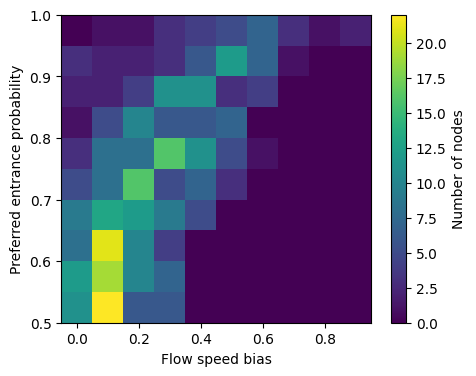

In [ ]:
# Reviewer: flow speed bias vs preferred entrance
f, a = plt.subplots(1, 1, figsize=(5, 4))
tmp_x = vis_fb_vs_BOA_t['v_raw_bias_ratio']
tmp_y = vis_fb_vs_BOA_t['p_c1']
tmp_x_bin = np.arange(-0.05, 1.05, 0.1)
tmp_y_bin = np.arange(0.5, 1.05, 0.05)
a.hist2d(tmp_x, tmp_y, bins=[tmp_x_bin, tmp_y_bin])
a.set_xlabel('Flow speed bias')
a.set_ylabel('Preferred entrance probability')
cbar = f.colorbar(a.collections[0], ax=a)
cbar.set_label('Number of nodes')
if save_fig_Q:
    fig_fp = os.path.join(vis_folder, f"{vis_fp_prefix}_flow_speed_bias_vs_preferred_entrance.png")
    io.print_image_in_several_formats(f, fig_fp)

### Fit phase seperation curve

In [25]:
vis_xn = 'c_avg_v_r_raw'
# vis_xn = 'c_avg_vf_r'
nf_fit_loss = 'linear'
use_std_weight_Q = False

In [26]:
tmp_fit_y_std = vis_fbf_data['c_ps_p_mse'].flatten() if use_std_weight_Q else None
tmp_fit_x = vis_fbf_data[vis_xn].flatten() 
tmp_fit_y = vis_fbf_data['c_ps_p_m'].flatten()
tmp_selected_idx = np.nonzero(np.ones(tmp_fit_y.shape, bool))[0] 

In [27]:
# Try outlier rejections
tmp_fix_x_or = tmp_fit_x[tmp_selected_idx]
tmp_fix_y_or = tmp_fit_y[tmp_selected_idx]
or_ipr = 2.223
# or_ipr = 1.5

or_iter = 0
lr_b_or = 1
while True: 
    fig_avg_or = NFTAnalysis.fit_phase_seperation_data(tmp_fix_x_or, tmp_fix_y_or, visQ=False, nf_loss=nf_fit_loss)
    if np.abs(fig_avg_or['b'] - lr_b_or) > 1e-3: 
        or_iter += 1
        lr_b_or = fig_avg_or['b']
    else: 
        break
    tmp_y_pred = NFTAnalysis.fit_phase_seperation_function(tmp_fix_x_or, lr_b_or)
    tmp_y_res = tmp_y_pred - tmp_fix_y_or
    tmp_y_res_stat = stat.compute_basic_statistics(tmp_y_res)
    tmp_y_inlier_range = stat.compute_percentile_outlier_threshold(tmp_y_res, ipr=or_ipr)
    tmp_is_inliner_Q = np.logical_and(tmp_y_res >= tmp_y_inlier_range[0], tmp_y_res <= tmp_y_inlier_range[1])
    tmp_selected_idx = tmp_selected_idx[tmp_is_inliner_Q]

    tmp_fix_x_or = tmp_fit_x[tmp_selected_idx]
    tmp_fix_y_or = tmp_fit_y[tmp_selected_idx]
    print(f"Fraction of inliners: {tmp_is_inliner_Q.mean():.3f}, {fig_avg_or}")

print(f"Converge after {or_iter} iterations")

Fraction of inliners: 0.981, {'num_data': 416, 'b': 1.6301761785547957, 'r2': 0.6630197931875129, 'b_e': 0.0032677906527968227}
Fraction of inliners: 0.995, {'num_data': 408, 'b': 1.765961204357181, 'r2': 0.7513462536160426, 'b_e': 0.002732059139055783}
Fraction of inliners: 1.000, {'num_data': 406, 'b': 1.771121407154483, 'r2': 0.7618900145343995, 'b_e': 0.0026126612148495796}
Converge after 3 iterations


In [28]:
tmp_selected_Q = np.zeros(tmp_fit_y.shape, bool)
tmp_selected_Q[tmp_selected_idx] = True
tmp_selected_Q = np.all(tmp_selected_Q.reshape(-1, 2), axis=1) 
tmp_inlier_idx = np.nonzero(tmp_selected_Q)[0]

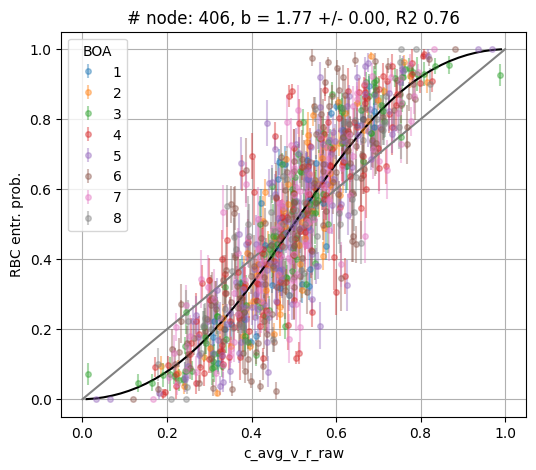

In [29]:
# Plot the phase seperation by branch order
rj_outlier_Q = True
if rj_outlier_Q: 
    vis_fbf_data_rjo = util.mask_data_in_dict(vis_fbf_data, tmp_selected_Q)
else: 
    vis_fbf_data_rjo = vis_fbf_data.copy()

tmp_idx_list, tmp_bo_list = util.bin_data_to_idx_list(vis_fbf_data_rjo['BOA'].astype(np.int16))
f = plt.figure(figsize=(6, 5))
a1 = f.add_subplot()
fit_result = {}
for tmp_idx, tmp_bo in zip(tmp_idx_list, tmp_bo_list): 
    tmp_x = vis_fbf_data_rjo[vis_xn][tmp_idx, :].flatten()
    tmp_y = vis_fbf_data_rjo['c_ps_p_m'][tmp_idx, :].flatten()
    tmp_ye = vis_fbf_data_rjo['c_ps_p_mse'][tmp_idx, :].flatten()

    a1.errorbar(tmp_x, tmp_y, tmp_ye, alpha=0.4, linestyle='none', fmt='o', label=f"{tmp_bo}", markersize=4)
    tmp_fit_y_std = tmp_ye if use_std_weight_Q else None
    tmp_fit_reuslt = NFTAnalysis.fit_phase_seperation_data(tmp_x, tmp_y, nf_loss=nf_fit_loss, y_std=tmp_fit_y_std)
    fit_result[tmp_bo] = tmp_fit_reuslt

fit_result = util.dict_of_dict_to_dict_of_array(fit_result)

a1.legend(title='BOA')
a1.grid()
a1.plot([0, 1], [0, 1], 'gray')
a1.set_xlabel(f"{vis_xn}")
a1.set_ylabel(f"RBC entr. prob.")

tmp_fit_y_std = vis_fbf_data_rjo['c_ps_p_mse'].flatten() if use_std_weight_Q else None
tmp_fit_x = vis_fbf_data_rjo[vis_xn].flatten() 
tmp_fit_y = vis_fbf_data_rjo['c_ps_p_m'].flatten()
fig_avg = NFTAnalysis.fit_phase_seperation_data(tmp_fit_x, tmp_fit_y, y_std=tmp_fit_y_std, visQ=False, nf_loss=nf_fit_loss)
lr_b = fig_avg['b']
plt_x = np.linspace(0.01, 0.99, 50)
plt_y = (plt_x ** lr_b / (plt_x ** lr_b + (1 - plt_x) ** lr_b))
a1.plot(plt_x, plt_y, 'k', label=f'b = {lr_b:.2f}')

a1.set_title(f"# node: {vis_fbf_data_rjo['BOA'].size}, b = {lr_b:.2f} +/- {fig_avg['b_e']:.2f}, R2 {fig_avg['r2']:.2f}")
# a1.set_aspect('equal')
a1.set_xlim(-0.05, 1.05)
if save_fig_Q: 
    if rj_outlier_Q: 
        fp = os.path.join(vis_folder, f"{z_folder_name}_phase_seperation_etr_prob_vs_{vis_xn}_min_data_{min_data}_rj_ol.png")
    else: 
        fp = os.path.join(vis_folder, f"{z_folder_name}_phase_seperation_etr_prob_vs_{vis_xn}_min_data_{min_data}.png")
    io.print_image_in_several_formats(f, fp)

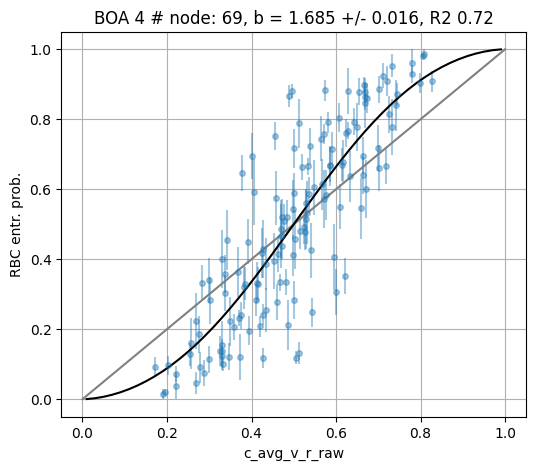

In [35]:
# nf_fit_loss = 'linear'
# use_std_weight_Q = False
vis_BOA = 4
f = plt.figure(figsize=(6, 5))
a1 = f.add_subplot()
tmp_idx = tmp_idx_list[np.nonzero(tmp_bo_list == vis_BOA)[0][0]]
tmp_x = vis_fbf_data_rjo[vis_xn][tmp_idx, :].flatten()
tmp_y = vis_fbf_data_rjo['c_ps_p_m'][tmp_idx, :].flatten()
tmp_ye = vis_fbf_data_rjo['c_ps_p_mse'][tmp_idx, :].flatten()

a1.errorbar(tmp_x, tmp_y, tmp_ye, alpha=0.4, linestyle='none', fmt='o', label=f"{tmp_bo}", markersize=4)
tmp_fit_y_std = tmp_ye if use_std_weight_Q else None
tmp_fit_reuslt = NFTAnalysis.fit_phase_seperation_data(tmp_x, tmp_y, nf_loss=nf_fit_loss, y_std=tmp_fit_y_std)
a1.grid()
a1.plot([0, 1], [0, 1], 'gray')
a1.set_xlabel(f"{vis_xn}")
a1.set_ylabel(f"RBC entr. prob.")

lr_b = tmp_fit_reuslt['b']
plt_x = np.linspace(0.01, 0.99, 50)
plt_y = (plt_x ** lr_b / (plt_x ** lr_b + (1 - plt_x) ** lr_b))
a1.plot(plt_x, plt_y, 'k', label=f'b = {lr_b:.2f}')
a1.set_title(f"BOA {vis_BOA} # node: {tmp_idx.size}, b = {lr_b:.3f} +/- {tmp_fit_reuslt['b_e']:.3f}, R2 {tmp_fit_reuslt['r2']:.2f}")

if save_fig_Q: 
    if rj_outlier_Q: 
        fp = os.path.join(vis_folder, f"{z_folder_name}_BOA_{vis_BOA}_phase_seperation_etr_prob_vs_{vis_xn}_min_data_{min_data}_rj_ol.png")
    else: 
        fp = os.path.join(vis_folder, f"{z_folder_name}_BOA_{vis_BOA}_phase_seperation_etr_prob_vs_{vis_xn}_min_data_{min_data}.png")
    io.print_image_in_several_formats(f, fp)

In [45]:
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

In [47]:
m_x = fit_result['key'].reshape(-1, 1)
my_y_std = fit_result['b_e'].reshape(-1, 1)
m_y = fit_result['b'].reshape(-1, 1)

X_design = sm.add_constant(m_x)
weights = 1 / (my_y_std ** 2)
model = sm.WLS(m_y, X_design, weights=weights)
results = model.fit()
print(results.summary())
# model = LinearRegression()
# model.fit(m_x, m_y)
# print("Intercept:", model.intercept_)
# print("Slope:", model.coef_[0])
# r2 = model.score(m_x, m_y)
# print("R²:", r2)

                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.767
Model:                            WLS   Adj. R-squared:                  0.728
Method:                 Least Squares   F-statistic:                     19.73
Date:                Sat, 21 Jun 2025   Prob (F-statistic):            0.00437
Time:                        18:48:28   Log-Likelihood:                 4.9818
No. Observations:                   8   AIC:                            -5.964
Df Residuals:                       6   BIC:                            -5.805
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.3376      0.134     17.472      0.0

/home/xij072/Software/miniconda3/envs/d2l/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


Finish saving figure as /net/birdstore/Vessel/Lightfield/Zhang2020/visualization/analysis/combined_stat/z400_550um_phase_seperation_c_avg_v_r_raw_fit_para_vs_BOA_min_data_25_rj_ol.pdf
Finish saving figure as /net/birdstore/Vessel/Lightfield/Zhang2020/visualization/analysis/combined_stat/z400_550um_phase_seperation_c_avg_v_r_raw_fit_para_vs_BOA_min_data_25_rj_ol.pickle
Finish saving figure as /net/birdstore/Vessel/Lightfield/Zhang2020/visualization/analysis/combined_stat/z400_550um_phase_seperation_c_avg_v_r_raw_fit_para_vs_BOA_min_data_25_rj_ol.png


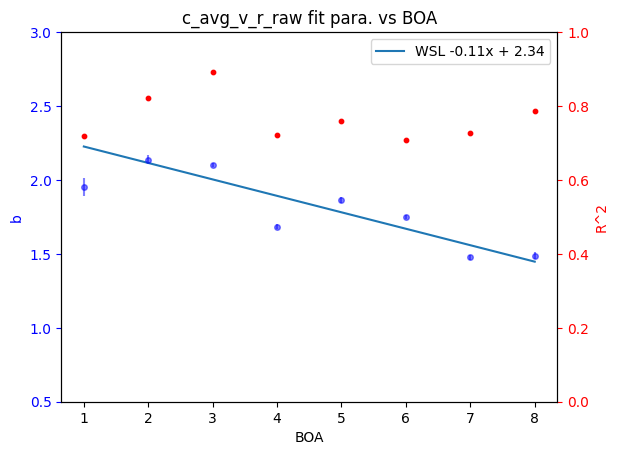

In [61]:
f, a = plt.subplots()
a.errorbar(fit_result['key'], fit_result['b'], fit_result['b_e'], alpha=0.5, linestyle='none', fmt='o', markersize=4, color='b')
f_y = results.params[0] + fit_result['key'] * results.params[1]
a.plot(fit_result['key'], f_y, label=f'WSL {results.params[1]:.2f}x + {results.params[0]:.2f}')
a.legend()
a1 = a.twinx()

a.set_xlabel(f"BOA")
a.set_ylabel(f"b", color='b')
a.tick_params(axis='y', colors='b')
a.set_title(f"{vis_xn} fit para. vs BOA")
a.set_ylim(0.5, 3.0)

a1.scatter(fit_result['key'], fit_result['r2'], 10, 'r')
a1.set_ylabel("R^2", color='r')
a1.tick_params(axis='y', colors='r')
a1.set_ylim(0, 1)

if save_fig_Q or True: 
    if rj_outlier_Q: 
        fp = os.path.join(vis_folder, f"{z_folder_name}_phase_seperation_{vis_xn}_fit_para_vs_BOA_min_data_{min_data}_rj_ol.png")
    else: 
        fp = os.path.join(vis_folder, f"{z_folder_name}_phase_seperation_{vis_xn}_fit_para_vs_BOA_min_data_{min_data}.png")
    io.print_image_in_several_formats(f, fp)